In [1]:
using Pkg
Pkg.add("Plots")
using Plots

   Resolving package versions...
  No Changes to `C:\Users\Admin\.julia\environments\v1.11\Project.toml`
  No Changes to `C:\Users\Admin\.julia\environments\v1.11\Manifest.toml`


In [5]:
f(x) = x^4 - 8x^2 + 10

# Метод Свенна
function svenn(f, x0, h)
    fm, f0, fp = f(x0 - h), f(x0), f(x0 + h)
    if fm >= f0 >= fp
        dir = 1.0
    elseif fm <= f0 <= fp
        dir = -1.0
    elseif fm >= f0 && fp >= f0
        return (x0 - h, x0 + h)
    else
        dir = fm < fp ? -1.0 : 1.0
    end
    step = h * dir
    x_prev, x_curr = x0, x0 + step
    for _ in 1:50
        step *= 2
        x_next = x_curr + step
        if f(x_next) > f(x_curr)
            return (min(x_prev, x_next), max(x_prev, x_next))
        end
        x_prev, x_curr = x_curr, x_next
    end
    return (min(x_prev, x_curr), max(x_prev, x_curr))
end

# Метод перебора
function brute_force(f, a, b, eps)
    n = min(ceil(Int, (b - a) / eps), 500000)
    xs = range(a, b, length=n)
    history = Float64[]
    x_best, f_best = a, f(a)
    for x in xs
        fx = f(x)
        if fx < f_best
            f_best = fx; x_best = x
        end
        push!(history, x_best)
    end
    step_h = max(1, length(history) ÷ 100)
    return x_best, b - a, n, history[1:step_h:end]
end

# Метод дихотомии
function dichotomy(f, a, b, eps)
    delta = eps / 4
    iters = 0
    history = Float64[]
    while (b - a) > eps
        mid = (a + b) / 2
        x1, x2 = mid - delta, mid + delta
        push!(history, mid)
        if f(x1) < f(x2)
            b = x2
        else
            a = x1
        end
        iters += 1
    end
    x_min = (a + b) / 2
    push!(history, x_min)
    return x_min, b - a, iters, history
end

# Метод золотого сечения
function golden_section(f, a, b, eps)
    phi = (sqrt(5) - 1) / 2
    iters = 0
    history = Float64[]
    x1 = b - phi * (b - a)
    x2 = a + phi * (b - a)
    f1, f2 = f(x1), f(x2)
    while (b - a) > eps
        push!(history, (a + b) / 2)
        if f1 < f2
            b = x2; x2 = x1; f2 = f1
            x1 = b - phi * (b - a); f1 = f(x1)
        else
            a = x1; x1 = x2; f1 = f2
            x2 = a + phi * (b - a); f2 = f(x2)
        end
        iters += 1
    end
    x_min = (a + b) / 2
    push!(history, x_min)
    return x_min, b - a, iters, history
end

# Метод Фибоначчи
function fibonacci(f, a, b, eps)
    F = [1, 1]
    while F[end] < (b - a) / eps
        push!(F, F[end] + F[end-1])
    end
    n = length(F) - 1; history = Float64[]
    x1 = a + F[n-1] / F[n+1] * (b - a)
    x2 = a + F[n] / F[n+1] * (b - a)
    f1, f2 = f(x1), f(x2)
    for k in 2:n
        push!(history, (a + b) / 2)
        if f1 > f2
            a, x1, f1 = x1, x2, f2
            idx = n - k + 1
            x2 = (idx >= 1 && idx + 1 <= length(F)) ? a + F[idx] / F[idx+1] * (b - a) : x1 + eps
            f2 = f(x2)
        else
            b, x2, f2 = x2, x1, f1
            idx = n - k
            x1 = (idx >= 1 && idx + 2 <= length(F)) ? a + F[idx] / F[idx+2] * (b - a) : x2 - eps
            f1 = f(x1)
        end
    end
    x_min = (a + b) / 2
    push!(history, x_min)
    return x_min, b - a, n, history
end

# Численные производные
df(f, x; h=1e-8) = (f(x + h) - f(x - h)) / (2h)
d2f(f, x; h=1e-5) = (f(x + h) - 2f(x) + f(x - h)) / h^2

# Проверка унимодальности
function check_unimodality(f, a, b; n=1000)
    xs = range(a, b, length=n)
    derivs = [df(f, x) for x in xs]
    changes = 0
    for i in 2:length(derivs)
        if derivs[i-1] * derivs[i] < 0
            changes += 1
        end
    end
    return changes
end

# Поиск экстремума всеми методами + график
function find_extremum(f, x0, h, eps; mode=:min)
    g = mode == :max ? x -> -f(x) : f
    label = mode == :max ? "МАКСИМУМ" : "МИНИМУМ"

    println("=" ^ 50)
    println("  $label")
    println("=" ^ 50)

    a, b = svenn(g, x0, h)
    println("Свенн: [$a, $b]")

    changes = check_unimodality(g, a, b)
    println("Унимодальность: смен знака f' = $changes → $(changes == 1 ? "унимодальна" : "не унимодальна")")

    x_bf, _, n_bf, h_bf = brute_force(g, a, b, eps)
    x_di, _, n_di, h_di = dichotomy(g, a, b, eps)
    x_gs, _, n_gs, h_gs = golden_section(g, a, b, eps)
    x_fb, _, n_fb, h_fb = fibonacci(g, a, b, eps)

    println("\n  Перебор:          x*=$(round(x_bf,digits=8)), f(x*)=$(round(f(x_bf),digits=8)), итераций=$n_bf")
    println("  Дихотомия:        x*=$(round(x_di,digits=8)), f(x*)=$(round(f(x_di),digits=8)), итераций=$n_di")
    println("  Золотое сечение:  x*=$(round(x_gs,digits=8)), f(x*)=$(round(f(x_gs),digits=8)), итераций=$n_gs")
    println("  Фибоначчи:        x*=$(round(x_fb,digits=8)), f(x*)=$(round(f(x_fb),digits=8)), итераций=$n_fb")

    fp = df(f, x_fb)
    fpp = d2f(f, x_fb)
    if mode == :max
        println("\nПравило дождя: f'=$(round(fp,digits=10)), f''=$(round(fpp,digits=4)) → $(fpp < 0 ? "максимум" : "не максимум")")
    else
        println("\nПравило дождя: f'=$(round(fp,digits=10)), f''=$(round(fpp,digits=4)) → $(fpp > 0 ? "минимум" : "не минимум")")
    end
    println("\nВыводы: Перебор($n_bf) >> Зол.сечение($n_gs) ≈ Фибоначчи($n_fb) > Дихотомия($n_di)")
    println()

    # График
    xs_plot = range(a, b, length=500)
    ys_plot = [f(x) for x in xs_plot]
    p = plot(xs_plot, ys_plot, label="f(x)", color=:black, lw=2,
             title="$label: f(x) = x⁴ − 8x² + 10", xlabel="x", ylabel="f(x)")
    scatter!(p, h_bf, [f(x) for x in h_bf], label="Перебор ($n_bf)", color=:red, ms=2, alpha=0.5)
    scatter!(p, h_di, [f(x) for x in h_di], label="Дихотомия ($n_di)", color=:blue, ms=4)
    scatter!(p, h_gs, [f(x) for x in h_gs], label="Зол. сечение ($n_gs)", color=:green, ms=4, shape=:utriangle)
    scatter!(p, h_fb, [f(x) for x in h_fb], label="Фибоначчи ($n_fb)", color=:orange, ms=4, shape=:rect)
    vline!(p, [x_fb - eps/2, x_fb + eps/2], label="ε = $eps", color=:purple, ls=:dash, lw=1.5)
    return p
end

eps = 1e-6
println("f(x) = x⁴ − 8x² + 10, ε = $eps\n")

p1 = find_extremum(f, 1.0, 0.5, eps; mode=:min)
p2 = find_extremum(f, 0.0, 0.5, eps; mode=:max)

p = plot(p1, p2, layout=(1, 2), size=(1400, 500))
savefig(p, "lab2.png")
println("График сохранён: lab2.png")

f(x) = x⁴ − 8x² + 10, ε = 1.0e-6

  МИНИМУМ
Свенн: [1.0, 2.5]
Унимодальность: смен знака f' = 1 → унимодальна

  Перебор:          x*=2.000001, f(x*)=-6.0, итераций=500000
  Дихотомия:        x*=1.99999986, f(x*)=-6.0, итераций=22
  Золотое сечение:  x*=2.0000002, f(x*)=-6.0, итераций=30
  Фибоначчи:        x*=1.99999966, f(x*)=-6.0, итераций=31

Правило дождя: f'=-1.10134e-5, f''=32.0 → минимум

Выводы: Перебор(500000) >> Зол.сечение(30) ≈ Фибоначчи(31) > Дихотомия(22)

  МАКСИМУМ
Свенн: [-0.5, 0.5]
Унимодальность: смен знака f' = 1 → унимодальна

  Перебор:          x*=-1.0e-6, f(x*)=10.0, итераций=500000
  Дихотомия:        x*=2.4e-7, f(x*)=10.0, итераций=21
  Золотое сечение:  x*=1.7e-7, f(x*)=10.0, итераций=29
  Фибоначчи:        x*=-7.4e-7, f(x*)=10.0, итераций=30

Правило дождя: f'=1.19016e-5, f''=-16.0 → максимум

Выводы: Перебор(500000) >> Зол.сечение(29) ≈ Фибоначчи(30) > Дихотомия(21)

График сохранён: lab2.png


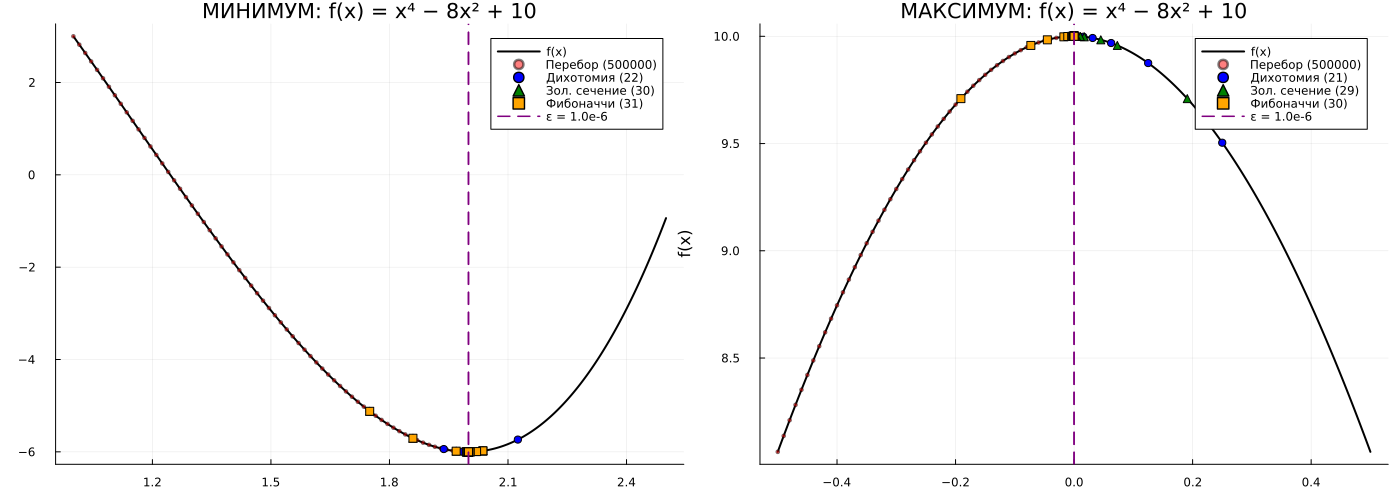

In [6]:
p